# Funnel Target: Compare SGLD and Neural Wasserstein Gradient Flow of the KL

In [26]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("../../learning_particle_gradients/")
from matplotlib.animation import FuncAnimation

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd

import utils
import plot
import distributions
import models
import flows
from tqdm import tqdm
key = random.PRNGKey(0)

import kernels
import metrics
# import seaborn as sns
# sns.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
%autoreload

In [28]:
# set up exporting
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False, # avoid unicode error on saving plots with negative numbers (??)
})

figure_path = "/home/lauro/documents/msc-thesis/thesis/figures/"
# save figures by using plt.savefig('path/to/fig')
# remember that latex textwidth is 5.4in
# so use figsize=[5.4, 4], for example
printsize = [5.4, 4]

# 2dim Funnel

In [29]:
n_steps = 5000
particle_lr = 1e-2
learner_lr = 1e-4
n_particles = 200
d = 2
PATIENCE = 0
# PATIENCE = 15 # try this

In [30]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)
target_samples = target.sample(n_particles)

In [31]:
%matplotlib inline

In [32]:
true_samples = target.sample(n_particles)
def plot_true(idx=np.array([0, -1]), ax=None):
    if ax is None:
        ax = plt.gca()
    lims=(-15, 15)
    ax.set(xlim=lims, ylim=lims)
    ax.scatter(*np.rollaxis(true_samples[:, idx], 1), alpha=0.25, label="True", marker=".", color="tab:blue")

In [33]:
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=5000, particle_lr=particle_lr, patience=PATIENCE, learner_lr=learner_lr, aux=False, compute_metrics=metrics.get_funnel_tracer(target_samples))
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=5000, particle_lr=particle_lr, compute_metrics=metrics.get_funnel_tracer(target_samples))
sgld_gradient2, sgld_particles2, err4    = flows.sgld_flow(     subkey, funnel_setup, n_particles=n_particles, n_steps=5000, particle_lr=particle_lr/5, compute_metrics=metrics.get_funnel_tracer(target_samples))
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=5000, particle_lr=particle_lr*5, scaled=True,  bandwidth=None, compute_metrics=metrics.get_funnel_tracer(target_samples))

# Note: I scaled the svgd step-size (by hand) so that it is maximial while still converging to a low MMD.

100%|██████████| 5000/5000 [03:39<00:00, 22.75it/s]


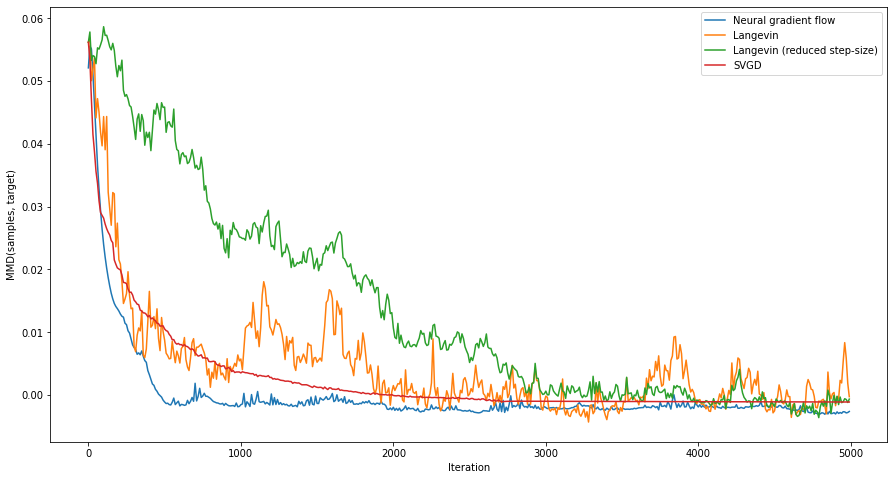

In [35]:
%matplotlib inline
plt.subplots(figsize=[15, 8])

typ = "funnel_"

plt.plot(*zip(*neural_particles.rundata[typ+"mmd"]), label="Neural gradient flow")
plt.plot(*zip(*sgld_particles.rundata[typ+"mmd"]), label="Langevin")
plt.plot(*zip(*sgld_particles2.rundata[typ+"mmd"]), label="Langevin (reduced step-size)")
plt.plot(*zip(*svgd_particles.rundata[typ+"mmd"]), label="SVGD")


plt.xlabel("Iteration")
plt.ylabel("MMD(samples, target)")

plt.legend()

Text(0.5, 1.0, 'SVGD')

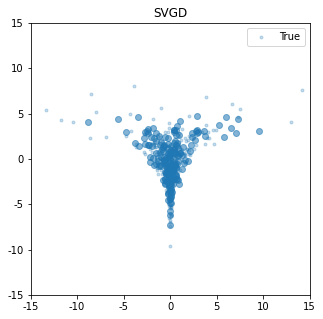

In [11]:
# svgd scatterplot
fig, ax = plt.subplots(figsize=[5,5])
plot_true(ax=ax)
ax.scatter(*np.rollaxis(svgd_particles.particles.training, 1), alpha=0.55)
ax.legend()
ax.set_title("SVGD")
# ax.set(xlim=lims, ylim=lims)

Text(0, 0.5, 'MMD(samples, target)')

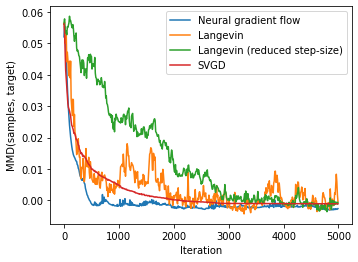

In [11]:
%matplotlib inline
plt.subplots(figsize=printsize)

typ = "funnel_"

plt.plot(*zip(*neural_particles.rundata[typ+"mmd"]), label="Neural gradient flow")
plt.plot(*zip(*sgld_particles.rundata[typ+"mmd"]), label="Langevin")
plt.plot(*zip(*sgld_particles2.rundata[typ+"mmd"]), label="Langevin (reduced step-size)")
plt.plot(*zip(*svgd_particles.rundata[typ+"mmd"]), label="SVGD")
plt.legend()

plt.xlabel("Iteration")
plt.ylabel("MMD(samples, target)")

# plt.savefig(figure_path + "funnel_mmd.pgf")

In [14]:
def plot_projection(idx, figsize=[20, 5]):
    sample_list = [p.particles.training for p in (neural_particles, sgld_particles, sgld_particles2)]
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    titles = ("Neural gradient flow", "Langevin") #+ ("Langevin (smaller stepsize)",)
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        plot_true(idx, ax)
        ax.scatter(*np.rollaxis(samples[:, idx], 1), alpha=0.5, marker=".")
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

In [15]:
%matplotlib inline
lims=(-15, 15)

idx = np.array([0, -1])
plot_projection(idx, figsize=[20, 8])

NameError: name 'sgld_particles2' is not defined

In [ ]:
idx = np.array([0, -1])
plot_projection(idx, figsize=printsize)
# plt.savefig(figure_path + "funnel_scatter.pgf")

In [15]:
# fig, axs = plt.subplots(1, 2, figsize=[15, 7])
# for ax in axs:
#     plot.scatter(vmap(kernels.desvgd_particlesize)(true_samples), ax=ax)
#     ax.set(ylim=[-3, 3], xlim=[-3, 3])

# plot.scatter(vmap(kernels.defunnelize)(neural_particles.particles.training), ax = axs[0])
# plot.scatter(vmap(kernels.defunnelize)(sgld_particles.particles.training), ax = axs[1])

# mmd = jit(metrics.get_mmd(kernels.get_funnel_kernel(1.)))

# true_samples = target.sample(n_particles*10)

# mmd(*[samples for samples in (neural_particles.particles.training, true_samples)])

# mmd(*[samples for samples in (sgld_particles.particles.training, true_samples)])

### neural metrics

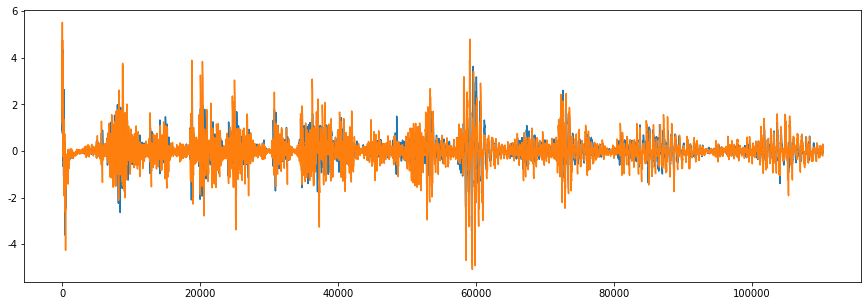

In [12]:
%matplotlib inline
plt.subplots(figsize=[15, 5])
plt.plot(neural_learner.rundata["training_loss"])
plt.plot(neural_learner.rundata["validation_loss"])

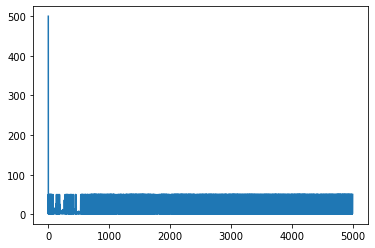

In [13]:
%matplotlib inline
plt.plot(neural_learner.rundata["train_steps"])

### animate projection

In [14]:
idx = np.array([0, -1])

In [15]:
neural_particles.rundata.keys()

dict_keys(['particles', 'step', 'test_mean', 'test_std', 'training_mean', 'training_std', 'rbf_mmd', 'funnel_mmd'])

In [16]:
trajectory = neural_particles.rundata["particles"].training
trajectory_projected = trajectory[:, :, idx]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

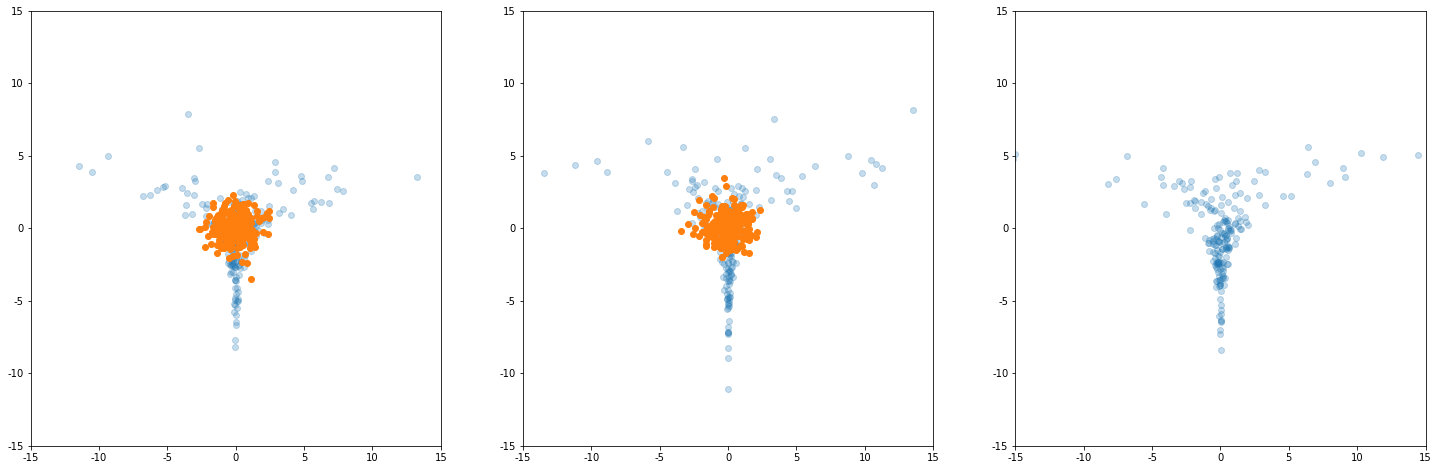

In [21]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 3, figsize=[25,8])
for ax in axs:
    ax.scatter(*np.rollaxis(target.sample(n_particles)[:, idx], 1), label="True", alpha=0.25)
    ax.set(xlim=lims, ylim=lims)


interval = 10
a=[]
a.append(plot.animate_array(trajectory_projected, fig, ax=axs[0], interval=interval))
a.append(plot.animate_array(sgld_particles.rundata["particles"].training, ax=axs[1], interval=interval))
# a.append(plot.animate_array(sgld_particles2.rundata["particles"].training, ax=axs[2], interval=interval))
a

In [15]:
from celluloid import Camera
writer = matplotlib.animation.writers['ffmpeg'](fps=30)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

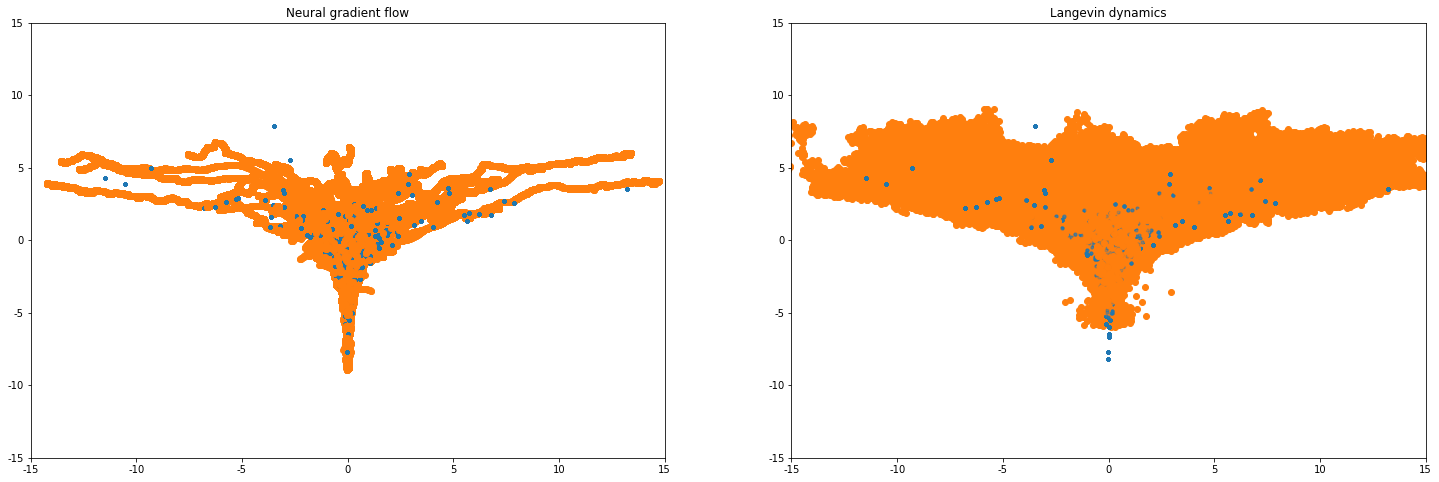

In [19]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 2, figsize=[25,8])
axs[0].set_title("Neural gradient flow")
axs[1].set_title("Langevin dynamics")

camera = Camera(fig)


for t in range(5000):
    sample_list = [p.rundata["particles"].training[t] for p in (neural_particles, sgld_particles)]
    for ax, samples in zip(axs, sample_list):
        plot_true(ax=ax)
        ax.scatter(*np.rollaxis(samples, 1), color="tab:orange")
    camera.snap()

anim = camera.animate()

In [20]:
anim.save("ngf-vs-pula.mp4", writer=writer, dpi=200)

# same thing but plus SVGD

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

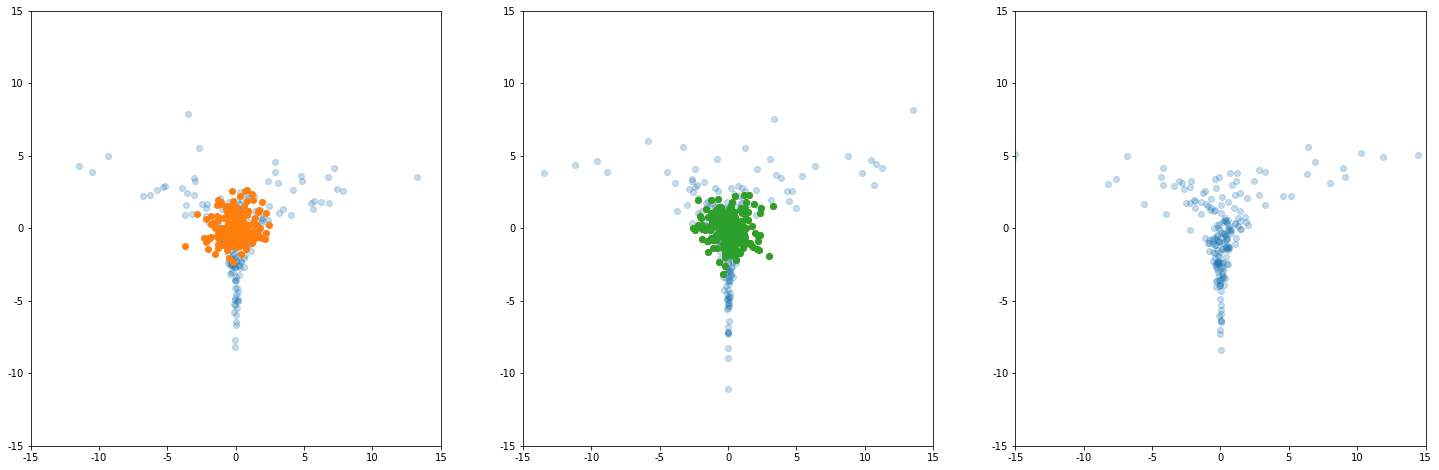

In [17]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 3, figsize=[25,8])
for ax in axs:
    ax.scatter(*np.rollaxis(target.sample(n_particles)[:, idx], 1), label="True", alpha=0.25)
    ax.set(xlim=lims, ylim=lims)


interval = 10
a=[]
a.append(plot.animate_array(trajectory_projected, fig, ax=axs[0], interval=interval))
a.append(plot.animate_array(sgld_particles.rundata["particles"].training, ax=axs[1], interval=interval))
# a.append(plot.animate_array(sgld_particles2.rundata["particles"].training, ax=axs[2], interval=interval))
a.append(plot.animate_array(svgd_particles.rundata["particles"].training, ax=axs[1], interval=interval)) # ADDED SVGD
a

In [18]:
from celluloid import Camera
writer = matplotlib.animation.writers['ffmpeg'](fps=30)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

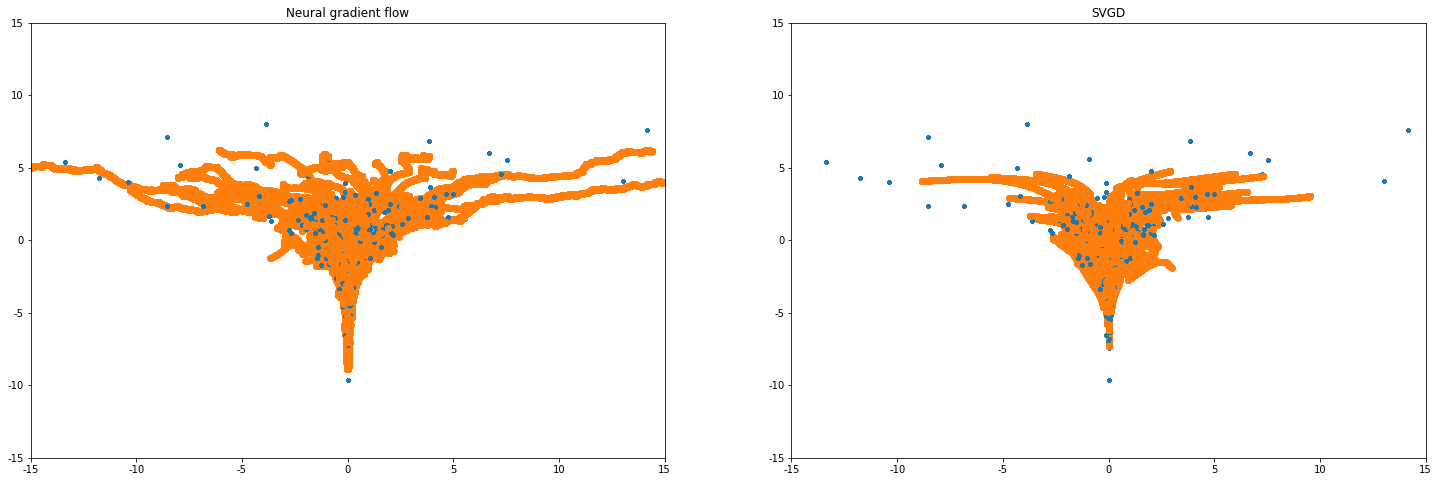

In [19]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 2, figsize=[25,8])
axs[0].set_title("Neural gradient flow")
# axs[1].set_title("Langevin dynamics")
axs[1].set_title("SVGD")
camera = Camera(fig)

ps = (neural_particles, svgd_particles)
# ps = (neural_particles, sgld_particles)
for t in range(5000):
    sample_list = [p.rundata["particles"].training[t] for p in ps]
    for ax, samples in zip(axs, sample_list):
        plot_true(ax=ax)
        ax.scatter(*np.rollaxis(samples, 1), color="tab:orange")
    camera.snap()

anim = camera.animate()

In [20]:
anim.save("ngf-vs-svgd.mp4", writer=writer, dpi=200)

# Same thing with `TFP`

In [23]:
key, subkey = random.split(key)

In [24]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [69]:
d = 2
dfunnel = distributions.Funnel(d)
dproposal = distributions.Gaussian(np.ones(d), 1)
target_log_prob = dfunnel.logpdf

# kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=target_log_prob, step_size=1e-2)
# kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob_fn=target_log_prob, step_size=particle_lr/5)

@jit
def run_chain(key, state):
    return tfp.mcmc.sample_chain(1_000_000,
      current_state=state,
      kernel=kernel,
      trace_fn = None,
#       trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=0,
      seed=key)

In [70]:
key, subkey = random.split(key)
single_chain_init = dproposal.sample(1, subkey)[0]
key, subkey = random.split(key)
single_chain = run_chain(subkey, single_chain_init)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '


In [71]:
# del single_chain

In [72]:
spaced_samples = single_chain[np.arange(0, 1_000_000, 1000)]

In [73]:
mmd = metrics.get_mmd(kernel=kernels.get_funnel_kernel(1.))

In [74]:
sequential_mmd = mmd(target_samples, spaced_samples)

In [75]:
sequential_mmd

DeviceArray(0.00933635, dtype=float32)

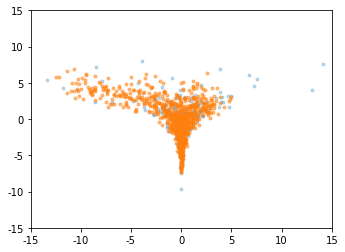

In [77]:
%matplotlib inline
fig, ax = plt.subplots(figsize=printsize)
plot_true(ax=ax)
plot.scatter(spaced_samples, ax=ax, alpha=0.5, marker=".")
# plt.savefig(figure_path + "sequential_ula_funnel_scatter.pgf")

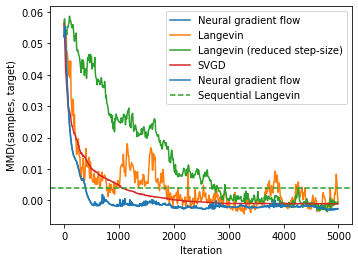

In [68]:
%matplotlib inline
plt.subplots(figsize=printsize)

typ = "funnel_"

plt.plot(*zip(*neural_particles.rundata[typ+"mmd"]), label="Neural gradient flow")
plt.plot(*zip(*sgld_particles.rundata[typ+"mmd"]), label="Langevin")
plt.plot(*zip(*sgld_particles2.rundata[typ+"mmd"]), label="Langevin (reduced step-size)")
plt.plot(*zip(*svgd_particles.rundata[typ+"mmd"]), label="SVGD")
plt.plot(*zip(*neural_particles.rundata[typ+"mmd"]), label="Neural gradient flow", color="tab:blue")

plt.axhline(y=sequential_mmd, label="Sequential Langevin", color="tab:green", linestyle="--")

plt.xlabel("Iteration")
plt.ylabel("MMD(samples, target)")

plt.legend()

# plt.savefig(figure_path + "funnel_mmd.pgf")

In [ ]:
# %matplotlib widget
# fig, ax = plt.subplots(figsize=[7,7])
# plot_true(ax=ax)
# plot.animate_array(single_chain[:, None, :], interval=1)

In [ ]:
sdjkfdk

# same thing in 3D

In [ ]:
%autoreload

In [ ]:
particle_lr = 5e-3
learner_lr = 5e-5
n_particles = 200
d = 25
PATIENCE = 0
# PATIENCE = 15 # try this

In [ ]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)
target_samples = target.sample(500)

In [ ]:
target_moment2 = np.array([9] + (d-1)*[90])

In [ ]:
key, subkey = random.split(key)
neural_learner_d, neural_particles_d, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=2000, particle_lr=particle_lr, patience=PATIENCE, learner_lr=learner_lr, aux=False, compute_metrics=metrics.get_2nd_moment_tracer(target_moment2))
sgld_gradient_d, sgld_particles_d, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=2000, particle_lr=particle_lr, compute_metrics=metrics.get_2nd_moment_tracer(target_moment2))
# sgld_gradient2_d, sgld_particles2_d, err4    = flows.sgld_flow(     subkey, funnel_setup, n_particles=n_particles, n_steps=10000, particle_lr=particle_lr/5, compute_metrics=metrics.get_2nd_moment_tracer(target_moment2))

In [ ]:
%matplotlib inline
plt.subplots(figsize=[15, 8])

plt.plot(*zip(*neural_particles_d.rundata["second_error"]), label="Neural")
plt.plot(*zip(*sgld_particles_d.rundata["second_error"]), label="SGLD")
# plt.plot(*zip(*sgld_particles2_d.rundata["second_error"]), label="SGLD (reduced step-size)")
# plt.plot(*zip(*svgd_particles.rundata["second_error"]), label="SVGD")
# plt.yscale("symlog")

plt.xlabel("Iteration")
plt.ylabel("MMD(samples, target)")

plt.legend()

In [ ]:
%matplotlib inline
plt.subplots(figsize=printsize)

typ = "funnel_"

plt.plot(*zip(*neural_particles_d.rundata[typ+"mmd"]), label="Neural gradient flow")
plt.plot(*zip(*sgld_particles_d.rundata[typ+"mmd"]), label="Langevin")
# plt.plot(*zip(*sgld_particles2_d.rundata[typ+"mmd"]), label="Langevin (reduced step-size)")
# plt.plot(*zip(*svgd_particles.rundata[typ+"mmd"]), label="SVGD")
plt.legend()

plt.xlabel("Iteration")
plt.ylabel("MMD(samples, target)")

# plt.savefig(figure_path + "funnel_mmd_3d.pgf")

In [ ]:
sgld_particles_d.particles.training[:, idx].shape

In [ ]:
np.rollaxis(sgld_particles_d.particles.training[:, idx], 1).shape

In [ ]:
idx = np.array([0, -1])
plot_true(idx)
plt.scatter(*np.rollaxis(sgld_particles_d.particles.training[:, idx], 1), alpha=0.9)

In [ ]:
def plot_projection(idx, figsize=[20, 5]):
    sample_list = [p.particles.training for p in (neural_particles_d, sgld_particles_d)]
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    titles = ("Neural gradient flow", "Langevin") #+ ("Langevin (smaller stepsize)",)
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        plot_true(idx, ax)
        ax.scatter(*np.rollaxis(samples[:, idx], 1), alpha=0.9)
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

In [ ]:
%matplotlib inline
lims=(-15, 15)

idx = np.array([0, -1])
plot_projection(idx, figsize=[20, 8])

In [ ]:
idx = np.array([0, -1])
plot_projection(idx, figsize=printsize)
# plt.savefig(figure_path + "funnel_scatter_3d.pgf")

# Animation

In [ ]:
idx = np.array([0, -1])

In [ ]:
# %matplotlib widget
# lims = (-15, 15)
# fig, axs = plt.subplots(1, 3, figsize=[25,8])
# for ax in axs:
#     plot_true(ax=ax)
    
# interval = 1
# a=[]
# a.append(plot.animate_array(neural_particles_d.rundata["particles"].training[:, :, idx], fig, ax=axs[0], interval=interval))
# a.append(plot.animate_array(  sgld_particles_d.rundata["particles"].training[:, :, idx], fig, ax=axs[1], interval=interval))
# # a.append(plot.animate_array(sgld_particles2.rundata["particles"].training, ax=axs[2], interval=interval))
# a